# Importing packages and loading data

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [3]:
path = os.getcwd() + '/data-analytics-case-study-dataset'
csv_files = glob.glob(os.path.join(path, "*.csv"))
csv_files.sort() # sort by ascending numbers

In [4]:
dfs = []
for i in range(len(csv_files)):
    dfs.append(pd.read_csv(csv_files[i]))

In [5]:
customers_df = dfs[0]
sellers_df = dfs[1]
geolocation_df = dfs[2]
products_df = dfs[3]
product_category_name_df = dfs[4]
orders_df = dfs[5]
order_items_df = dfs[6]
order_payments_df = dfs[7]
order_reviews = dfs[8]
mql_df = dfs[9]
closed_deals_df = dfs[10]


# Setting up figure aesthetics

In [210]:
sns.set_style("white")
flatui = ["#D45500", "#ED9500", "#A10E01"]
sns.set_palette(flatui)

# Analyzing overall sales performane of LoMo

To do this we can study the gross merchandise value on Lomo's ecommerce platform. First calculate the total order value = product + freight in the order items df. Then merge order items df with orders df to get GMV time series.

In [6]:
# checking for NA values
order_items_df.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [7]:
order_value_df = order_items_df.groupby('order_id').sum().reset_index()[['order_id', 'price', 'freight_value']]
# order_value_df['total_value'] = order_value_df.price + order_value_df.freight_value

In [8]:
gmv_df = pd.merge(orders_df, order_value_df, how='inner', on='order_id')[['order_id','order_approved_at','price','freight_value']]

In [9]:
# checking datatypes
gmv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98666 entries, 0 to 98665
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           98666 non-null  object 
 1   order_approved_at  98652 non-null  object 
 2   price              98666 non-null  float64
 3   freight_value      98666 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.8+ MB


In [10]:
gmv_df.isnull().sum()

order_id              0
order_approved_at    14
price                 0
freight_value         0
dtype: int64

Note that order approved at is not in datetime format and we have 14 null values.

In [11]:
# drop na values since there are just 14
gmv_df = gmv_df.dropna(axis = 0)

In [12]:
# converting order_approved_at to date time
gmv_df.order_approved_at = pd.to_datetime(gmv_df.order_approved_at)

In [13]:
gmv_df['year'] = gmv_df.order_approved_at.dt.year

# Sort by year
gmv_df = gmv_df.sort_values('year')

In [14]:
# group by year and aggregate
gmv_by_year = gmv_df.groupby('year').sum()

In [15]:
gmv_by_year.rename(columns={'price': 'sale_value'}, inplace=True)

In [197]:
gmv_by_year.reset_index(inplace=True)

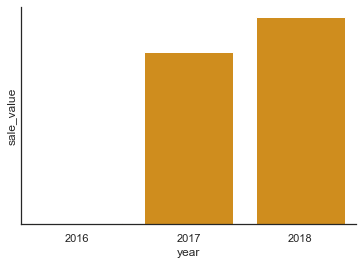

In [215]:
sns.barplot(x = 'year',
            y = 'sale_value',
            color= '#ED9500',
            data = gmv_by_year)
plt.yticks([])
sns.despine();

# Exploring best product category

In [17]:
# Merging dataframes to get product names in english
products_df_english = pd.merge(products_df, product_category_name_df, left_on='product_category_name', right_on='product_category_name_portugese', how='left').drop(columns=['product_category_name_portugese'])

By merging products and order items dataframes, we can group the products by product category and aggregate total value sold, average, etc.

But before that, lets check for null values and clean up the data where necessary

In [18]:
products_df_english.isnull().sum()

product_id                        0
product_category_name             0
product_name_lenght               0
product_description_lenght        0
product_photos_qty                0
product_weight_g                  0
product_length_cm                 0
product_height_cm                 0
product_width_cm                  0
product_category_name_english    13
dtype: int64

It appears that we have 13 null values in `product_category_name_english` column

In [19]:
products_df_english.loc[products_df_english.product_category_name_english.isnull(), ['product_category_name', 'product_category_name_english']]

,product_category_name,product_category_name_english
1581,pc_gamer,NaN
5703,portateis_cozinha_e_preparadores_de_alimentos,NaN
7176,portateis_cozinha_e_preparadores_de_alimentos,NaN
7326,pc_gamer,NaN
8647,portateis_cozinha_e_preparadores_de_alimentos,NaN
10822,portateis_cozinha_e_preparadores_de_alimentos,NaN
13995,portateis_cozinha_e_preparadores_de_alimentos,NaN
15874,portateis_cozinha_e_preparadores_de_alimentos,NaN
16608,pc_gamer,NaN
17459,portateis_cozinha_e_preparadores_de_alimentos,NaN


Upon inspection, it seems that there was no english translation for two product categories in the product category name translation dataframe. To deal with this we can leave these 2 products in their portugese names but replace the other names with their english names and drop `product_category_name_english`

In [20]:
# Dictionary for translation
cat_name_translation = dict(zip(product_category_name_df.product_category_name_portugese, product_category_name_df.product_category_name_english))

In [21]:
products_df_english.product_category_name = products_df_english.product_category_name.replace(cat_name_translation)

In [22]:
products_df_english.drop(columns='product_category_name_english', inplace=True)
products_df_english.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [23]:
order_items_df.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

No null values in order items dataframe

In [24]:
print("Number of unique product categories: {}".format(products_df_english.product_category_name.nunique()))

Number of unique product categories: 73


Now we can merge order and product dataframes.

In [25]:
product_order_df = pd.merge(products_df_english[['product_id', 'product_category_name']], order_items_df, how = 'inner', on='product_id')

## Visualising Top 10 Product Categories

### Top 10 by Sales

<AxesSubplot:ylabel='Product Category Name'>

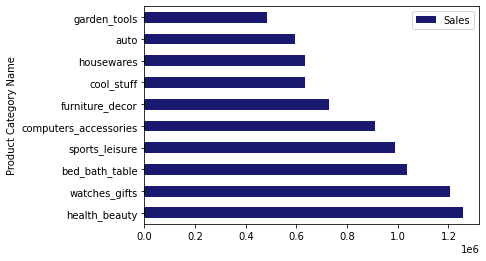

In [26]:
# Group by product categories and aggregate sales
total_sales_by_product = product_order_df.groupby('product_category_name').sum().reset_index()[['product_category_name', 'price']]

# Filter out top 10 highest sales product categories
top10sales = total_sales_by_product.sort_values('price', ascending=False).head(10).rename(columns = {'product_category_name': 'Product Category Name' ,'price': 'Sales'})

# Plot 
top10sales.plot(kind = 'barh', y = 'Sales', x = 'Product Category Name', color = 'midnightblue')

Health Beauty products have the highest gross sales on Lomo's platform

### Top 10 by Volume

<AxesSubplot:ylabel='Product Category Name'>

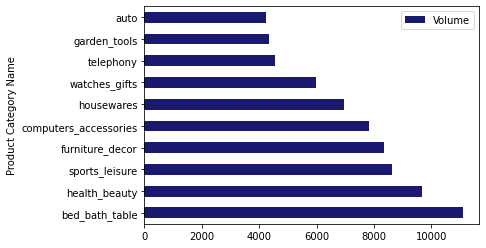

In [27]:
# Group by product categories and aggregate volume
total_volume_by_product = product_order_df.groupby('product_category_name').size().reset_index(name = 'volume')[['product_category_name', 'volume']]

# Filter out top 10 highest sales product categories
top10vol = total_volume_by_product.sort_values('volume', ascending=False).head(10).rename(columns = {'product_category_name': 'Product Category Name' ,'volume': 'Volume'})

# Plot 
top10vol.plot(kind = 'barh', y = 'Volume', x = 'Product Category Name', color = 'midnightblue')

# Product Category with the highest potential

One way to find the product category with the highest potential is using product rating

Another way is to find products that have been trending up

In [29]:
product_ts = pd.merge(product_order_df, orders_df, how="inner", on='order_id')[['order_approved_at', 'product_category_name', 'price']]

In [30]:
product_ts.isnull().sum()

order_approved_at        14
product_category_name     0
price                     0
dtype: int64

Drop null order approved dates

In [31]:
product_ts.dropna(axis=0, inplace=True)

In [32]:
product_ts.isnull().sum()

order_approved_at        0
product_category_name    0
price                    0
dtype: int64

Creating new datetime column, using order_approved_at column as our date

In [33]:
product_ts['Year'] = product_ts['order_approved_at'].apply(lambda x: str(x)[6:10])
product_ts['Month'] = product_ts['order_approved_at'].apply(lambda x: str(x)[3:5])
product_ts['Day'] = product_ts['order_approved_at'].apply(lambda x: str(x)[:2])
product_ts['ds'] = pd.DatetimeIndex(product_ts['Year'] + '-' + product_ts['Month'] + '-' + product_ts['Day'])

We can find the highest 1 year % change in total sales for every product category, then pick out the top 10

In [36]:
def one_year_sales_growth(product_name):
    return product_ts[product_ts['product_category_name'] == product_name].groupby('Year').sum().pct_change().price[-1]

In [37]:
product_list = product_ts['product_category_name'].unique()
sales_growth_dict = {product_name : one_year_sales_growth(product_name) for product_name in product_list}

In [38]:
top5_potential = sorted(sales_growth_dict, key = sales_growth_dict.get, reverse=True)[:5]

In [222]:
# % Growth in products
for product in top5_potential:
    print(one_year_sales_growth(product))

55.72335300200742
16.851184210526316
9.942919217855026
8.1345017121091
7.976201438848921


Plot function for product category time series

In [34]:
def plot_product_sales_trend(product_name):
    product_ts[product_ts['product_category_name'] == product_name].groupby('ds').sum().plot()
    plt.title("Plot for {}".format(product_name))

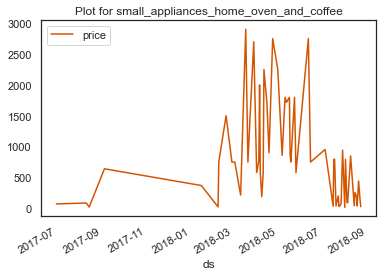

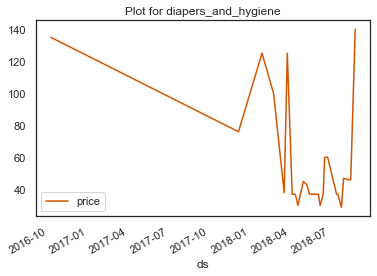

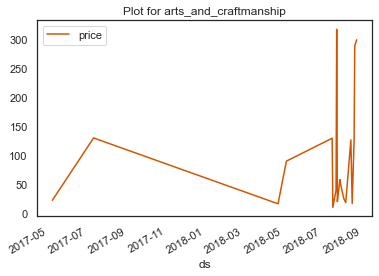

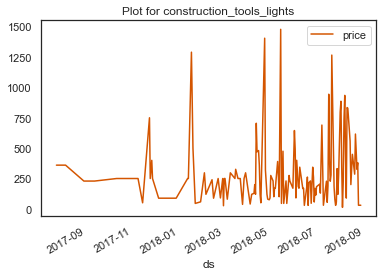

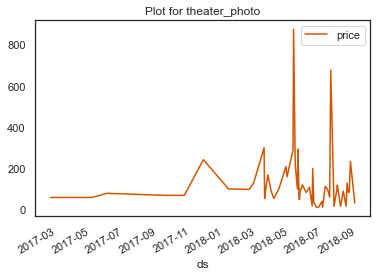

In [223]:
# Visualizing the growth in sales of top 5 highest potential products
for product in top5_potential:
    plot_product_sales_trend(product)

# Forecasting Sales Performance

In [246]:
def forecast_sales(product):
    # Slicing dataframe by product
    df = product_ts[product_ts.product_category_name == product]
    df = df.groupby('ds').sum().reset_index().rename(columns = {'price': 'y'})
    
    # Training Model
    m = Prophet(interval_width=0.95, daily_seasonality=True, yearly_seasonality=True)
    model = m.fit(df)
    
    # Forecast
    future = m.make_future_dataframe(periods = 100, freq ='D')
    forecast = m.predict(future)
    m.plot(forecast)



Initial log joint probability = -116.878
Iteration  1. Log joint probability =    35.7545. Improved by 152.632.
Iteration  2. Log joint probability =    64.5467. Improved by 28.7921.
Iteration  3. Log joint probability =    76.8556. Improved by 12.3089.
Iteration  4. Log joint probability =    77.1716. Improved by 0.315989.
Iteration  5. Log joint probability =    77.1755. Improved by 0.00394317.
Iteration  6. Log joint probability =    77.3767. Improved by 0.201233.
Iteration  7. Log joint probability =    77.3773. Improved by 0.000526052.
Iteration  8. Log joint probability =    77.3778. Improved by 0.000524341.
Iteration  9. Log joint probability =    77.3781. Improved by 0.000346341.
Iteration 10. Log joint probability =    77.3782. Improved by 5.71153e-05.
Iteration 11. Log joint probability =    77.3782. Improved by 6.20324e-06.
Iteration 12. Log joint probability =    77.3783. Improved by 5.8457e-05.
Iteration 13. Log joint probability =    77.3783. Improved by 4.86144e-06.
Ite

INFO:fbprophet:n_changepoints greater than number of observations. Using 20.



Initial log joint probability = -100.938
Iteration  1. Log joint probability =    3.56502. Improved by 104.503.
Iteration  2. Log joint probability =    16.8835. Improved by 13.3185.
Iteration  3. Log joint probability =    28.0533. Improved by 11.1698.
Iteration  4. Log joint probability =    31.7181. Improved by 3.66478.
Iteration  5. Log joint probability =    45.3215. Improved by 13.6035.
Iteration  6. Log joint probability =    58.3744. Improved by 13.0529.
Iteration  7. Log joint probability =    64.9382. Improved by 6.56372.
Iteration  8. Log joint probability =    77.1988. Improved by 12.2606.
Iteration  9. Log joint probability =    85.2627. Improved by 8.0639.
Iteration 10. Log joint probability =    85.8362. Improved by 0.573513.
Iteration 11. Log joint probability =    85.8652. Improved by 0.0289626.
Iteration 12. Log joint probability =    86.1985. Improved by 0.333343.
Iteration 13. Log joint probability =    86.2381. Improved by 0.0396301.
Iteration 14. Log joint probab

INFO:fbprophet:n_changepoints greater than number of observations. Using 14.



Initial log joint probability = -105.727
Iteration  1. Log joint probability =    7.87279. Improved by 113.599.
Iteration  2. Log joint probability =    16.6264. Improved by 8.75363.
Iteration  3. Log joint probability =    25.4252. Improved by 8.79882.
Iteration  4. Log joint probability =    28.8775. Improved by 3.45226.
Iteration  5. Log joint probability =      29.88. Improved by 1.00246.
Iteration  6. Log joint probability =    30.0315. Improved by 0.151593.
Iteration  7. Log joint probability =      30.09. Improved by 0.0584871.
Iteration  8. Log joint probability =    30.4726. Improved by 0.382563.
Iteration  9. Log joint probability =    30.4744. Improved by 0.00184398.
Iteration 10. Log joint probability =    30.4798. Improved by 0.00533883.
Iteration 11. Log joint probability =      30.48. Improved by 0.000174067.
Iteration 12. Log joint probability =    30.4816. Improved by 0.00167324.
Iteration 13. Log joint probability =    30.4904. Improved by 0.00877796.
Iteration 14. L

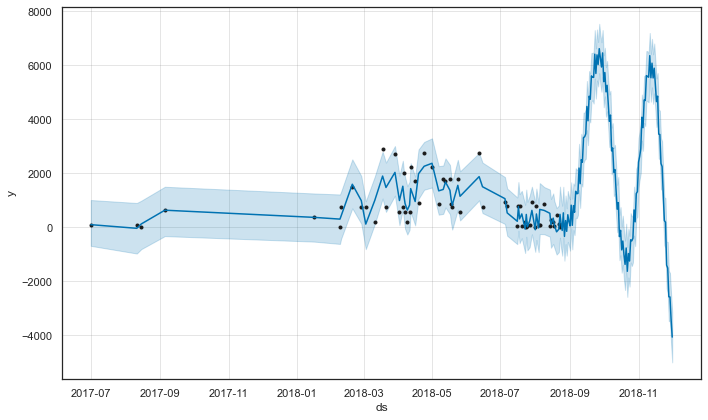

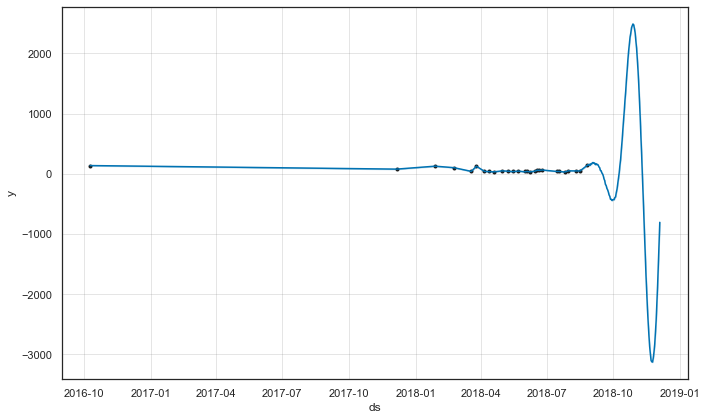

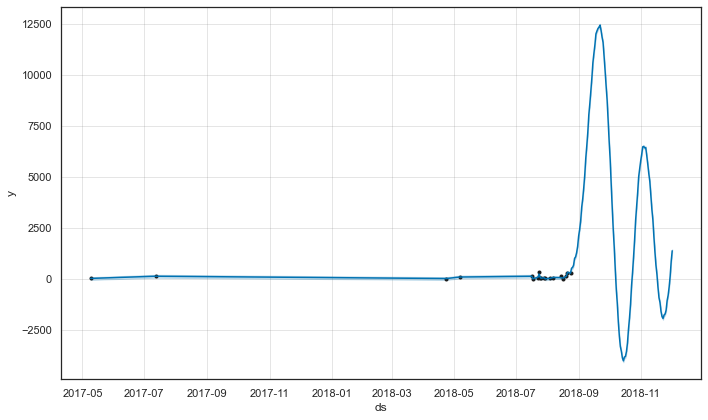

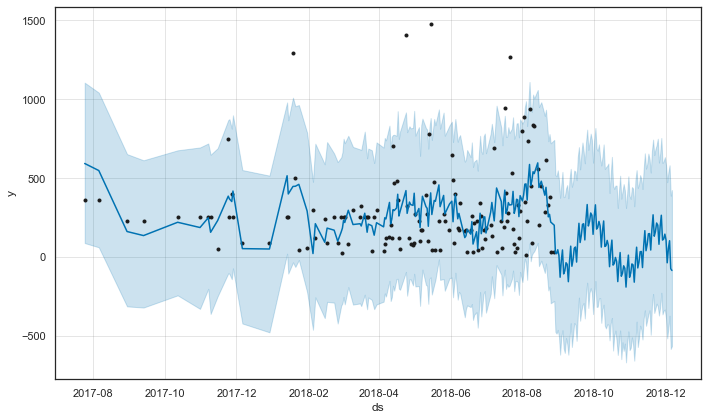

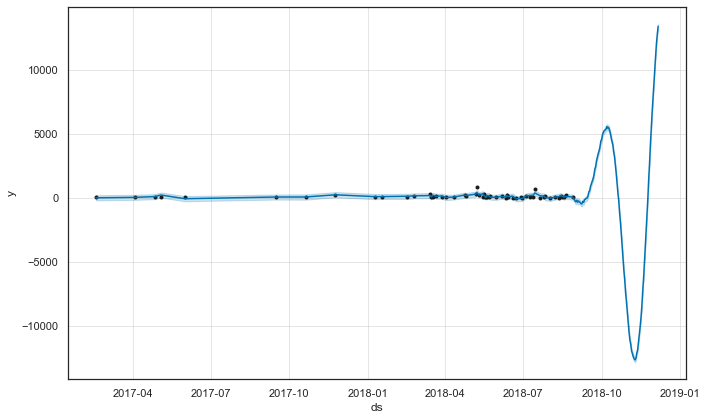

In [251]:
for product in top5_potential:
    forecast_sales(product)

Group by date and transform to sales | ds dataframe to be read into Prophet model

In [40]:
df_prophet = product_ts.groupby('ds').sum().reset_index().rename(columns = {'price': 'y'})

## Training Model

In [241]:
m = Prophet(interval_width=0.95, daily_seasonality=True, yearly_seasonality=True)
model = m.fit(df_prophet)

Initial log joint probability = -13.6384
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1343.23    0.00827244       141.112           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       1343.84   0.000376446        159.26    3.11e-06       0.001      202  LS failed, Hessian reset 
     164       1344.03   0.000356117       82.8514   4.064e-06       0.001      328  LS failed, Hessian reset 
     199       1344.06    5.0853e-06        72.422           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       1344.32    0.00143584       232.584   1.068e-05       0.001      540  LS failed, Hessian reset 
     299       1344.41   8.03058e-05       59.7548      0.8831      0.8831      551   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

## Forecast

In [242]:
future = model.make_future_dataframe(periods = 100, freq ='D')
forecast = model.predict(future)

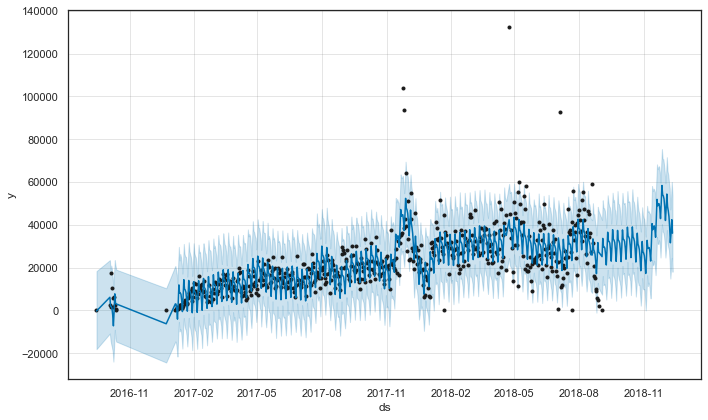

In [243]:
plot1 = m.plot(forecast) 

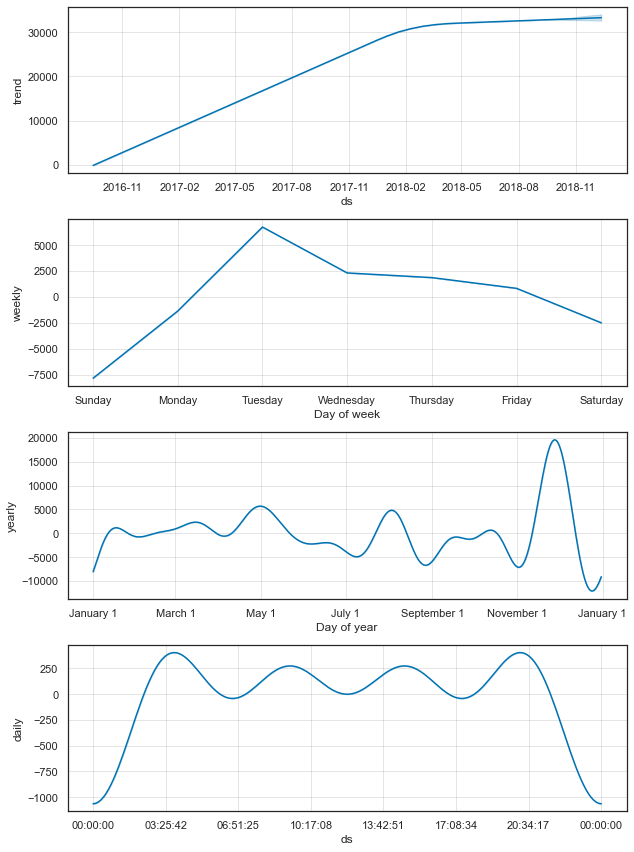

In [244]:
plot2 = m.plot_components(forecast)

# Geospatial Analysis

In [145]:
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import MarkerCluster

In [67]:
th_gdf = gpd.read_file("thailand_shp/tha_admbnda_adm1_rtsd_20190221.shp")

In [46]:
customer_loc_df = customers_df[['customer_unique_id' ,'customer_city', 'customer_state']]

In [47]:
customer_loc_df['query'] = customer_loc_df['customer_state'] + ' ' + customer_loc_df['customer_city']

/var/folders/3w/jcd4m_yd28g3x8_2jm8s9k580000gn/T/ipykernel_15502/2981928517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_loc_df['query'] = customer_loc_df['customer_state'] + ' ' + customer_loc_df['customer_city']


In [48]:
long_lat_df = pd.DataFrame({'query': customer_loc_df['query'].unique(), 'long': "", 'lat': ""})

In [49]:
geolocator = Nominatim(user_agent="myApp")
longitude = []
latitude = []

for i in long_lat_df.index:
    try:
        # try to fetch address from geopy
        location = geolocator.geocode(long_lat_df['query'][i])
        
        # append lat/long to column using dataframe location
        longitude.append(location.latitude)
        latitude.append(location.longitude)

    except:
        # catch exception for the case where no value is returned
        # append null value to column
        longitude.append(np.nan)
        latitude.append(np.nan)

long_lat_df['long'] = longitude
long_lat_df['lat'] = latitude

In [56]:
df_customer_geo = pd.merge(long_lat_df, customer_loc_df, how="inner", on='query')

In [57]:
df_customer_geo.shape

(99441, 6)

In [58]:
df_customer_geo.isnull().sum()

query                    0
long                  3845
lat                   3845
customer_unique_id       0
customer_city            0
customer_state           0
dtype: int64

Since 3845 out of 99441 rows is relatively small we should be able to drop the null values and it should not affect our analysis much.

In [59]:
df_customer_geo.dropna(axis=0, inplace = True)

In [60]:
# specifying EPSG: 4326 CRS
crs = {'init': 'epsg:4326'}

In [108]:
geometry = [Point(xy) for xy in zip(df_customer_geo['lat'], df_customer_geo['long'])]

In [109]:
geo_df = gpd.GeoDataFrame(df_customer_geo,
                           crs = crs,
                           geometry= geometry)

geo_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,query,long,lat,customer_unique_id,customer_city,customer_state,geometry
0,Bangkok Phra Nakhon,13.746852,100.501238,05c0c68fbdf283e56b37df9f2d20245c,Phra Nakhon,Bangkok,POINT (100.50124 13.74685)
1,Bangkok Phra Nakhon,13.746852,100.501238,1f69219bc86e6918b4751692323de642,Phra Nakhon,Bangkok,POINT (100.50124 13.74685)
2,Bangkok Phra Nakhon,13.746852,100.501238,31b5e7b0290cf70ac603e77f85efb53f,Phra Nakhon,Bangkok,POINT (100.50124 13.74685)
3,Bangkok Phra Nakhon,13.746852,100.501238,3f6faa55fa7e82f1245fff7e2118663b,Phra Nakhon,Bangkok,POINT (100.50124 13.74685)
4,Bangkok Phra Nakhon,13.746852,100.501238,3fb97204945ca0c01bcf3eee6031c5f1,Phra Nakhon,Bangkok,POINT (100.50124 13.74685)


In [110]:
cities = geo_df.drop_duplicates(subset = 'query')

In [169]:
geo_perc_users = geo_df.groupby('query').size().apply(lambda x: x/geo_df.shape[0])

In [170]:
cities = cities.merge(geo_perc_users.rename('perc_users'), on='query')

In [191]:
th_map = folium.Map(tiles = "cartodbpositron")

marker_cluster = MarkerCluster().add_to(th_map)

for i in range(len(cities)):
    lat = cities.iloc[i]['lat']
    long = cities.iloc[i]['long']
    radius = 5
    popup_text = """City State: {}<br>
    % of customers: {}<br>"""
    popup_text = popup_text.format(cities.iloc[i]['query'], cities.iloc[i]['perc_users'])
    
    folium.CircleMarker(location = [long, lat], radius = radius, popup = popup_text, fill = True).add_to(marker_cluster)

th_map